<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Imports" data-toc-modified-id="Data-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Imports</a></span></li><li><span><a href="#Data-Examination" data-toc-modified-id="Data-Examination-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Examination</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li><li><span><a href="#Error-distribution" data-toc-modified-id="Error-distribution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Error distribution</a></span></li><li><span><a href="#Bootstrapping" data-toc-modified-id="Bootstrapping-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bootstrapping</a></span></li><li><span><a href="#Confidence-interval-calculation" data-toc-modified-id="Confidence-interval-calculation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Confidence interval calculation</a></span></li></ul></div>

# Simulation Forecasting Confidence Interval

In this notebook I'll be explaining how to give a reservoir simulation forecast a probabilistic confidence measure, taking into account the quality of history matching.

Techniques used in this notebook:
* Bootstrapping
* Confidence interval estimation

## Data Imports

I've prepared a syntethic dataset that will be used for this demonstartion.

Suppose that this is field oil rate, but in essence this approach can be used for any metric.

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [9]:
data = pd.read_csv("data_increased_precision.csv")

## Data Examination

In [10]:
data.head()

,timestep,fopr,foprh,interval
0,01.01.2000,10.000000,11.714000,HIST
1,01.02.2000,10.100000,11.823060,HIST
2,01.03.2000,9.696000,10.217645,HIST
3,01.04.2000,9.405120,10.767922,HIST
4,01.05.2000,10.063478,10.376453,HIST


The data is succsessfully imported.

In here we have timesteps (every month), intervals (HIST for history, FRCST for forecast) and calculated and historic oil rates (FOPR and FOPRH respectively per ECLIPSE mnemonics).

I'll convert the timesteps into datetime format that will make plotting easier.

In [11]:
data["timestep"] = pd.to_datetime(data["timestep"], format="%d.%m.%Y")

### Plotting

Now let's plot our values and see how they look.

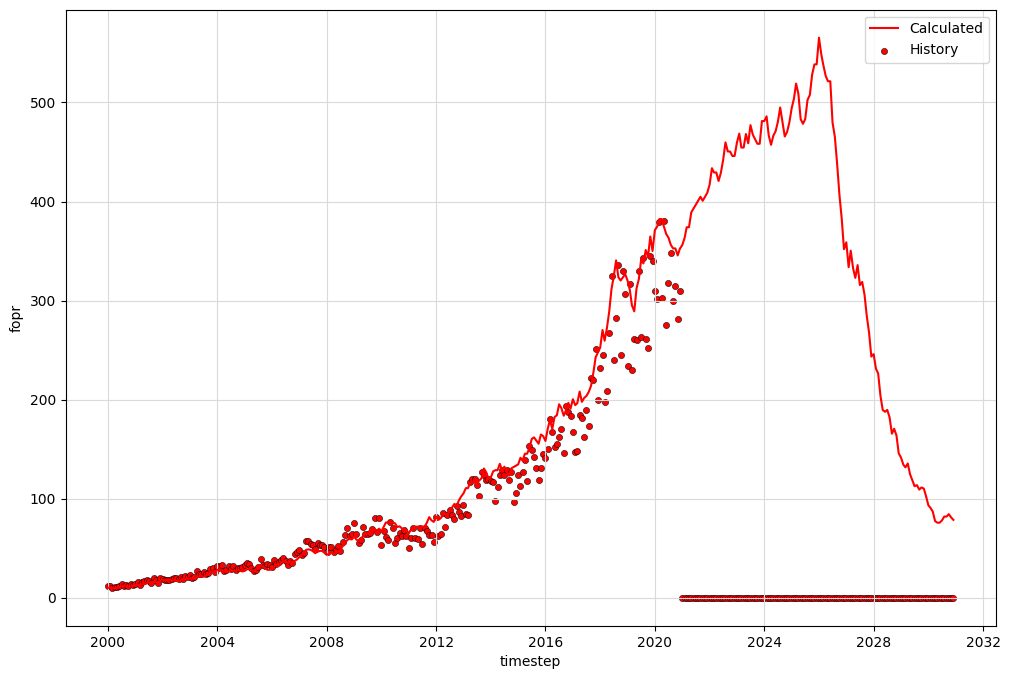

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.grid(color="#DADADA")
sns.lineplot(x=data["timestep"], y=data["fopr"], color="red", label="Calculated")
sns.scatterplot(x=data["timestep"], y=data["foprh"], color="red", markers="o", s=20,
                label="History", edgecolor="black"
               )
plt.legend();

As you can see, we have 20 years of history plus 10 years of forecast.

The calculated values appear to be on average lower than history for the first 10 years, after which they're systematically higher than history.

Clearly, the forecast values given by the model are somewhat incorrect since there's an appreciable mismatch between history and the calculated values.

Let's gauge how precise this forecast truly is.

## Error distribution

We'll start by calculating relative error for all the history points and plotting it on a histogram.

In [13]:
data["rel_err"] = data.apply(lambda row: (row["fopr"] / row["foprh"]) if row["interval"] == "HIST" else np.nan, axis=1)

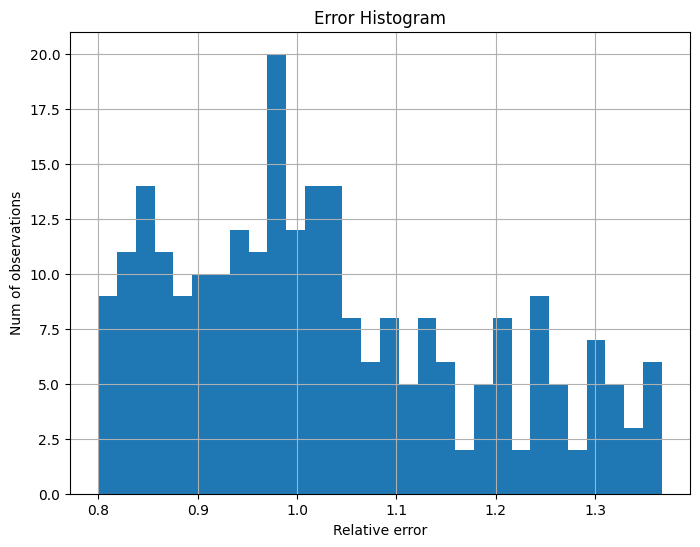

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

data["rel_err"].hist(bins=30)
ax.set_ylabel("Num of observations")
ax.set_xlabel("Relative error")
ax.set_title("Error Histogram");

In [15]:
data["rel_err"].describe()

count    252.000000
mean       1.030147
std        0.151159
min        0.799872
25%        0.912059
50%        1.001653
75%        1.127970
max        1.367241
Name: rel_err, dtype: float64

As we can see, the distribution is noticably right-skewed with median landing just to the right of unity.

## Bootstrapping

Since what we have is a non-normally distributed sample and we're interested in the properties of the population of errors (which is unknown), we'll be using bootstrapping to infer the properties of the population.

Bootstrapping is a method which implies:
* Sampling of data from the available sample (relative history in our case) with replacement, i.e. one value can be sample multiple times
* Calculating a parameter for this fresh sample, in our case that would be the quantiles equal to the boundaries of the confidence interval.
* Storing the calculated parameter
* Repeating the above for a large number of times

The result would be a distribution whose parameters (mean and variance) would be functionally identical to the population, per central limit theorem (CLT).

In practice, with this amount of data, the results will be quite similar to simply taking quantiles from known errors and using those as our confidence interval boundaries. This approach, however, allows performing such an analysis in cases when there's not much available data (less than 100 points).

All that's left is to implement this approach.

In [16]:
bootstrap_N = 10000
lows = []
highs = []

for _ in tqdm(range(bootstrap_N)):
    resample = data[data["interval"] == "HIST"].sample(frac=1, replace=True)["rel_err"]
    lows.append(pd.Series(resample).quantile(0.05))
    highs.append(pd.Series(resample).quantile(0.95))

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Q95')

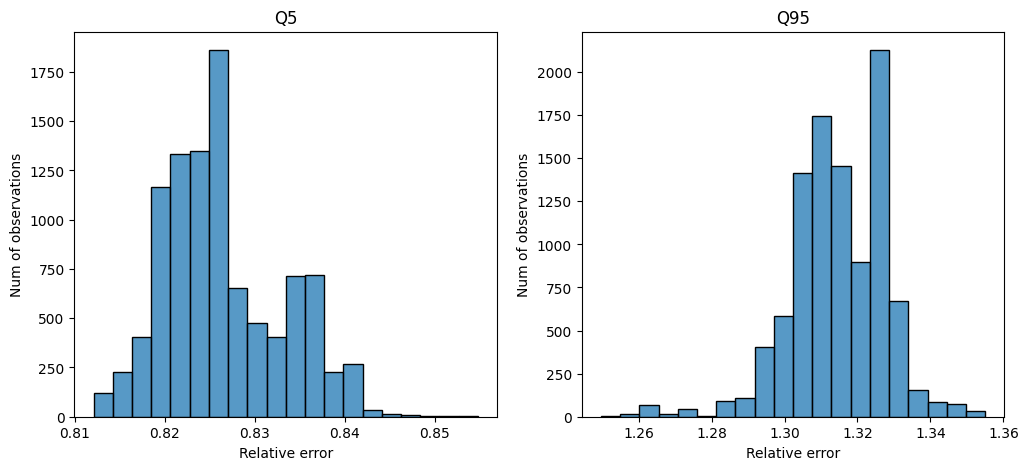

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=lows, bins=20, ax=ax[0])
ax[0].set_ylabel("Num of observations")
ax[0].set_xlabel("Relative error")
ax[0].set_title("Q5")

sns.histplot(x=highs, bins=20, ax=ax[1])
ax[1].set_ylabel("Num of observations")
ax[1].set_xlabel("Relative error")
ax[1].set_title("Q95");

As you can see, these histograms are fairly normally distributed and give a pretty good idea of the boundaries whithin which the error quantiles may land.

Now they can be used to calculate the confidence interval.

## Confidence interval calculation

For calculating confidence interval I will be using means of these distributions.

In [18]:
lower_conf = pd.Series(lows).mean()
upper_conf = pd.Series(highs).mean()

Now let's plot these values on the graph.

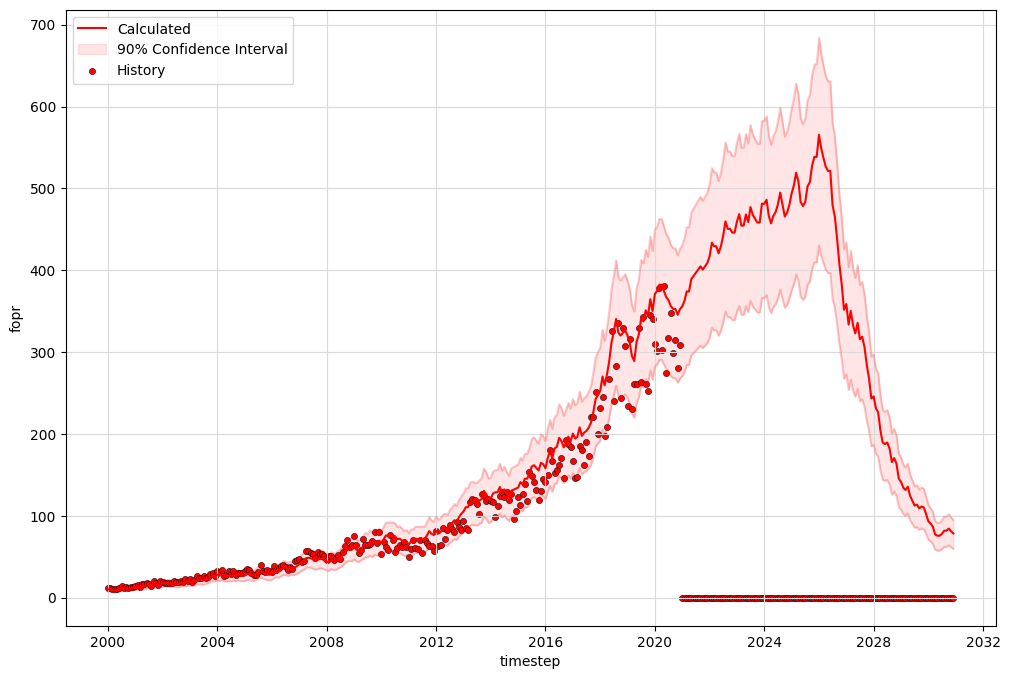

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.grid(color="#DADADA")

sns.lineplot(x=data["timestep"], y=data["fopr"], color="red", label="Calculated")
sns.lineplot(x=data["timestep"], y=data["fopr"]/lower_conf, color="red", alpha=.2)  ## Upper confidence interval boundary
sns.lineplot(x=data["timestep"], y=data["fopr"]/upper_conf, color="red", alpha=.2)  ## Lower confidence interval boundary
plt.fill_between(x=data["timestep"], y1=data["fopr"]/lower_conf, y2=data["fopr"]/upper_conf, color="red", alpha=.1, label="90% Confidence Interval")

sns.scatterplot(x=data["timestep"], y=data["foprh"], color="red", markers="o", label="History", edgecolor="black", s=20)
plt.legend();

As you can see, the vast majority of our points lie within the confidence interval.

Further verification would be to count the number of points outside of the interval, approx. 5% should be above it with approx. 5% below it.

In [59]:
outliers_low = data[(data["interval"] == "HIST") & (data["foprh"] < data["fopr"] / upper_conf)].shape[0]
outliers_high = data[(data["interval"] == "HIST") & (data["foprh"] > data["fopr"] / lower_conf)].shape[0]
hist_len = data[(data["interval"] == "HIST")].shape[0]


print(f"Number of historic timesteps: {hist_len}")
print(f"Number of points above than the confidence interval: {outliers_high}, which is {outliers_high / hist_len :.2%} of all historic timesteps")
print(f"Number of points below than the confidence interval: {outliers_low}, which is {outliers_low / hist_len :.2%} of all historic timesteps")

Number of historic timesteps: 252
Number of points above than the confidence interval: 15, which is 5.95% of all historic timesteps
Number of points below than the confidence interval: 13, which is 5.16% of all historic timesteps


The result is expected, approx. 5% of points lie to each side of the confidence interval.

It should be noted, however, that this entire analysis only gives the confidence interval related to the inaccuracy of the model itself. That is, if the actions performed in reality (regarding liquid production, for example) do not match those performed in the model, significant number of points may appear outside of the confidence interval.

## Conclusion

* A technique for estimating confidence interval for reservoir simulation forecast is shown
* Bootstrapping can be used for estimating confidence intervals for this specific application
* Such an analysis only accounts for the error caused by the model